In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])

import matplotx

%matplotlib inline

In [3]:
from rdkit import Chem

In [4]:
all_res = glob("out/**/*.pkl")

In [5]:
res = load_pickle(all_res[0])

In [6]:
from collections import defaultdict

In [7]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [8]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:

        metrics = {
            "noise_level": res["noise_level"],
            "temp": temp_res["temperature"],
            "frac_valid": temp_res["frac_valid"],
            "frac_unique": temp_res["frac_unique"],
            "frac_smiles_in_train": temp_res["frac_smiles_in_train"],
            "frac_smiles_in_pubchem": temp_res["frac_smiles_in_pubchem"],
            "kld": temp_res["kld"],
            "frechet_d": temp_res["frechet_d"],
            "frechet_score": temp_res["frechet_score"],
            "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
            / len(temp_res["valid_smiles"]),
        }

        generated_smiles.update([s for s in temp_res["generated_smiles"] if is_valid(s)])
        v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

        v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
        generated_smiles_at_temp[temp_res["temperature"]].update(v)

        for me, v in temp_res["e_pi_pi_star_metrics"].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res["z_pi_pi_star_metrics"].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [9]:
contains_azo(list(generated_smiles)[5])

True

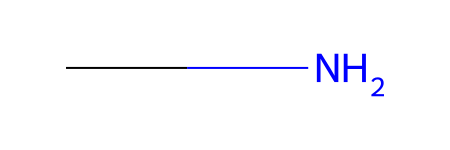

In [10]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [11]:
df = pd.DataFrame(compiled_res)

In [12]:
grouped = df.groupby(["temp"]).agg(["mean", "std"])

In [13]:
grouped

noise_level            frac_valid           frac_unique            \
            mean        std       mean       std        mean       std   
temp                                                                     
0.00    8.795455  14.605657   0.990119  0.039677    0.035801  0.020283   
0.10    8.795455  14.605657   0.982213  0.035744    0.063274  0.031656   
0.20    8.795455  14.605657   0.975791  0.035805    0.125734  0.036822   
0.50    8.795455  14.605657   0.972332  0.015992    0.378159  0.042755   
0.75    8.795455  14.605657   0.904150  0.034149    0.569111  0.042501   
1.00    8.795455  14.605657   0.697134  0.048063    0.765702  0.052566   
1.25    8.795455  14.605657   0.328063  0.047514    0.910613  0.062158   
1.50    8.795455  14.605657   0.119565  0.034373    1.000000  0.000000   
2.00    8.795455  14.605657   0.125000  0.035619    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem            ...  \
                     mean  std                   mean       std  ...   
temp                                                             ...   
0.00                  0.0  0.0                1.00000  0.000000  ...   
0.10                  0.0  0.0                1.00000  0.000000  ...   
0.20                  0.0  0.0                1.00000  0.000000  ...   
0.50                  0.0  0.0                1.00000  0.000000  ...   
0.75                  0.0  0.0                1.00000  0.000000  ...   
1.00                  0.0  0.0                1.00000  0.000000  ...   
1.25                  0.0  0.0                1.00000  0.000000  ...   
1.50                  0.0  0.0                1.00000  0.000000  ...   
2.00                  0.0  0.0                0.98514  0.041278  ...   

     z_pi_pi_star_r2           z_pi_pi_star_max_error             \
                mean       std                   mean        std   
temp                                                               
0.00       -0.039003  0.054202              62.605635  26.657359   
0.10       -0.032567  0.041412              62.921448  27.610857   
0.20       -0.068512  0.061114              63.979738  26.337726   
0.50       -0.140544  0.101781              72.040015  27.679257   
0.75       -0.200312  0.156756              74.004944  26.295129   
1.00       -0.310559  0.220785              71.309080  20.537239   
1.25       -0.481394  0.374110              58.007739  18.597581   
1.50       -3.219314  4.619669              64.198918  27.520313   
2.00       -4.269248  3.374932              69.750942  18.374038   

     z_pi_pi_star_mean_absolute_error             \
                                 mean        std   
temp                                               
0.00                        17.455859   8.627077   
0.10                        17.479638   8.516610   
0.20                        17.828361   8.895970   
0.50                        18.143392   8.557321   
0.75                        18.133473   8.740847   
1.00                        18.923018   8.133444   
1.25                        18.910230   6.845933   
1.50                        29.655726  12.866272   
2.00                        34.175314   4.808963   

     z_pi_pi_star_mean_squared_error              z_pi_pi_star_rmse             
                                mean          std              mean        std  
temp                                                                            
0.00                      641.252528   770.419877         23.078591  10.667899  
0.10                      641.350411   772.190036         23.097006  10.630889  
0.20                      664.477033   797.632561         23.478114  10.892580  
0.50                      688.725763   784.583526         24.129607  10.562134  
0.75                      710.873683   852.955109         24.397028  11.007554  
1.00                      733.071670   714.310083         25.310420   9.841591  
1.25                      663.470497   580.870825         24.405760   8.429671  

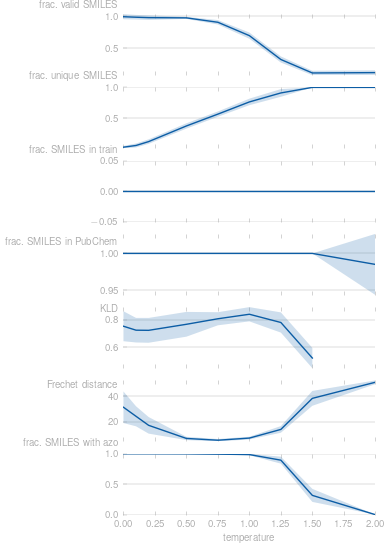

In [14]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
    ax[0].fill_between(
        grouped.index,
        grouped["frac_valid"]["mean"] - grouped["frac_valid"]["std"],
        grouped["frac_valid"]["mean"] + grouped["frac_valid"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. valid SMILES", ax=ax[0])

    ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
    ax[1].fill_between(
        grouped.index,
        grouped["frac_unique"]["mean"] - grouped["frac_unique"]["std"],
        grouped["frac_unique"]["mean"] + grouped["frac_unique"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. unique SMILES", ax=ax[1])

    ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
    ax[2].fill_between(
        grouped.index,
        grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["std"],
        grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in train", ax=ax[2])

    ax[3].plot(
        grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
    )
    ax[3].fill_between(
        grouped.index,
        grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["std"],
        grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES in PubChem", ax=ax[3])

    ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
    ax[4].fill_between(
        grouped.index,
        grouped["kld"]["mean"] - grouped["kld"]["std"],
        grouped["kld"]["mean"] + grouped["kld"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("KLD", ax=ax[4])

    ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
    ax[5].fill_between(
        grouped.index,
        grouped["frechet_d"]["mean"] - grouped["frechet_d"]["std"],
        grouped["frechet_d"]["mean"] + grouped["frechet_d"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Frechet distance", ax=ax[5])

    ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
    ax[6].fill_between(
        grouped.index,
        grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["std"],
        grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("frac. SMILES with azo", ax=ax[6])

    ax[-1].set_xlabel("temperature", labelpad=4)

    fig.savefig("photoswitch_random_smiles_metrics.pdf", bbox_inches="tight")

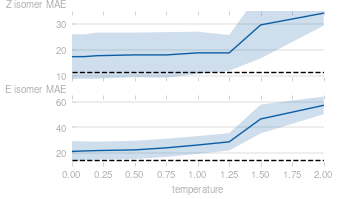

In [15]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        2, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
    )

    ax[0].plot(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[0].fill_between(
        grouped.index,
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["z_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("Z isomer MAE", ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")

    ax[0].set_ylim(8, 35)

    ax[1].plot(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
        label="e_pi_pi_star_metrics",
    )
    ax[1].fill_between(
        grouped.index,
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        - grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
        + grouped["e_pi_pi_star_mean_absolute_error"]["std"],
        alpha=0.2,
    )

    matplotx.ylabel_top("E isomer MAE", ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")

    ax[-1].set_xlabel("temperature", labelpad=4)
    ax[1].set_ylim(10, 65)
fig.savefig("random_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [16]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [17]:
import os
import shutil

In [18]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [19]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 405/405 [00:03<00:00, 109.04it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 406/406 [00:03<00:00, 119.74it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 410/410 [00:03<00:00, 110.59it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 466/466 [00:04<00:00, 110.79it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 593/593 [00:06<00:00, 89.54it/s] 


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 774/774 [00:11<00:00, 67.92it/s] 


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 710/710 [00:05<00:00, 122.64it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 614/614 [00:07<00:00, 80.94it/s] 


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 654/654 [00:04<00:00, 143.33it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [20]:
make_figure(1.5)

100%|██████████| 614/614 [00:05<00:00, 109.75it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html